In [2]:
import sys
sys.path.append("..")
from docopt import docopt
import logging
import neptune
import numpy as np
import syft as sy
from torch import load
from random import seed, sample, choice
from torch import optim, float32, int64, tensor
from torchvision import transforms
from federated_learning.FLCustomDataset import FLCustomDataset
from federated_learning.FederatedLearning import FederatedLearning
from federated_learning.helper import utils
CONFIG_PATH = '../configs/defaults.yml'

configs = utils.load_config(CONFIG_PATH)
logging.basicConfig(format='%(asctime)s %(message)s', level=configs['log']['level'])
seed(configs['runtime']['random_seed'])

import matplotlib.pyplot as plt
def draw_samples(data, key):
    print("Drawing for a sample user ({})".format(key))
    data_np = dict()
    data_np['x'] = np.array(data[key]['x'], dtype = np.float32).reshape(-1, 28, 28)
    data_np['y'] = np.array(data[key]['y'], dtype = np.int64).reshape(-1, 1)
    figure = plt.figure(figsize=(10,8))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.axis("off")
        plt.title(data_np['y'][i])
        plt.imshow(data_np['x'][i], cmap='gray')
        
        
        
def get_flattted_data(data):
    data_flatted_x = np.array([], dtype = np.float32).reshape(0, 28 * 28)
    tmp_array = [np.array(data_['x'], dtype = np.float32).reshape(-1, 28 * 28) for data_ in data.values()]
    for dd in tmp_array:
        data_flatted_x = np.concatenate((data_flatted_x, dd))
    data_flatted_y = np.array([], dtype = np.float32)
    tmp_array_y = [np.array(data_['y'], dtype = np.int64).reshape(-1) for data_ in data.values()]
    for dd in tmp_array_y:
        data_flatted_y = np.concatenate((data_flatted_y, dd))

    return data_flatted_x, data_flatted_y

In [3]:
# Logging initialization
log_enable = False
output_dir = None
neptune_enable = False

epochs_num = configs['runtime']['epochs']
rounds_num = configs['runtime']['rounds']

fl = FederatedLearning(
        configs['runtime']['batch_size'], 
        configs['runtime']['test_batch_size'], 
        configs['runtime']['lr'], 
        configs['runtime']['reg'],
        configs['runtime']['momentum'], 
        neptune_enable, log_enable, 
        configs['log']['interval'], 
        output_dir, 
        configs['runtime']['random_seed'])

fl.create_server()
fl.create_server_model()

raw_train_data = utils.preprocess_leaf_data(
    utils.load_leaf_train(configs['data']['FEMNIST_PATH']), only_digits=True
)
raw_test_data = utils.preprocess_leaf_data(
    utils.load_leaf_test(configs['data']['FEMNIST_PATH']), min_num_samples=configs['runtime']['test_batch_size'], only_digits=True
)

# common users in processed test/train dataset
workers_idx_all = sorted(list(set(raw_test_data.keys()).intersection(raw_train_data.keys())))

workers_idx_to_be_used = utils.get_workers_idx(
    workers_idx_all,
    configs['runtime']['femnist_users_num'],
    []
)

# fl.create_workers(workers_idx_to_be_used)
# fl.create_workers_model(workers_idx_to_be_used)

# trusted_idx = utils.get_workers_idx(
#     range(total_num_workers), configs['runtime']['mnist_trusted_users_num'], [])
eavesdroppers_idx = utils.get_workers_idx(
                        workers_idx_to_be_used, configs['runtime']['femnist_eavesdropper_num'], [])
normal_idx = utils.get_workers_idx(
                        workers_idx_to_be_used, 
                        len(workers_idx_to_be_used) - int(configs['runtime']['femnist_eavesdropper_num']),
                        eavesdroppers_idx)

# logging.info("Trusted: {}".format(trusted_idx))
logging.info("Eavesdroppers: {}".format(eavesdroppers_idx))
logging.info("Normal: {}".format(normal_idx))
if log_enable:
    utils.write_to_file(output_dir, "all_users", workers_idx_all)
    utils.write_to_file(output_dir, "eavesdroppers", eavesdroppers_idx)
    utils.write_to_file(output_dir, "normal", normal_idx)


2020-12-20 16:44:31,603 Initializing Federated Learning class...
2020-12-20 16:44:31,943 Creating the server...
2020-12-20 16:44:31,944 Creating a model for the server...
2020-12-20 16:44:31,949 Loading train dataset from /home/ubuntu/data/leaf_non_iid/data/femnist/data
2020-12-20 16:44:31,950 Loading 1 out of 4 files...
2020-12-20 16:44:35,030 Loading 2 out of 4 files...
2020-12-20 16:44:37,936 Loading 3 out of 4 files...
2020-12-20 16:44:40,911 Loading 4 out of 4 files...
2020-12-20 16:44:44,747 Start processing of femnist data...
2020-12-20 16:44:47,267 Loading test dataset from /home/ubuntu/data/leaf_non_iid/data/femnist/data
2020-12-20 16:44:47,269 Loading 1 out of 4 files...
2020-12-20 16:44:47,549 Loading 2 out of 4 files...
2020-12-20 16:44:47,839 Loading 3 out of 4 files...
2020-12-20 16:44:48,187 Loading 4 out of 4 files...
2020-12-20 16:44:48,481 Start processing of femnist data...
2020-12-20 16:44:48,625 Eavesdroppers: ['f0666_20', 'f0877_17', 'f0673_28', 'f0836_28', 'f0898

In [3]:
utils.dataset_info(raw_train_data)
utils.dataset_info(raw_test_data)

100:	10
101:	16
102:	16
103:	12
104:	13
105:	12
106:	21
107:	14
108:	25
109:	10
110:	15
111:	17
112:	9
113:	9
114:	6
115:	12
116:	8
117:	7
118:	3
119:	4
120:	2
121:	1
Mean num of samples/user: 110.0
Total Samples:	26174
Total Users:	242
[f0640_19]: Images: 112, Pixels: 28
mean: 0.9644982814788818
std: 0.15883949398994446,
max: 1.0
-----
15:	20
16:	17
17:	10
18:	8
19:	4
20:	3
Mean num of samples/user: 18.0
Total Samples:	1022
Total Users:	62
[f0717_46]: Images: 16, Pixels: 28
mean: 0.9649903178215027
std: 0.1575230360031128,
max: 1.0
-----


In [4]:
import copy
raw_train_attacked_1 = utils.perfrom_attack_femnist(
                copy.deepcopy(raw_train_data), 
                1,
                workers_idx_to_be_used,
                eavesdroppers_idx
            )
raw_train_attacked_2 = utils.perfrom_attack_femnist(
                copy.deepcopy(raw_train_data), 
                2,
                workers_idx_to_be_used,
                eavesdroppers_idx
            )
raw_train_attacked_3 = utils.perfrom_attack_femnist(
                copy.deepcopy(raw_train_data), 
                3,
                workers_idx_to_be_used,
                eavesdroppers_idx
            )

2020-12-20 16:46:55,184 Attack ID: 1
2020-12-20 16:46:55,185 Performing attack on ['f0666_20', 'f0877_17', 'f0673_28', 'f0836_28', 'f0898_29', 'f0841_10', 'f0862_25', 'f0840_37', 'f0958_28', 'f0644_19']
2020-12-20 16:46:55,238 Attack ID: 2
2020-12-20 16:46:55,239 Performing attack on ['f0666_20', 'f0877_17', 'f0673_28', 'f0836_28', 'f0898_29', 'f0841_10', 'f0862_25', 'f0840_37', 'f0958_28', 'f0644_19']
2020-12-20 16:46:56,643 Attack ID: 3
2020-12-20 16:46:56,644 Performing attack on ['f0666_20', 'f0877_17', 'f0673_28', 'f0836_28', 'f0898_29', 'f0841_10', 'f0862_25', 'f0840_37', 'f0958_28', 'f0644_19']


In [6]:
utils.dataset_info(raw_train_attacked_1)

100:	5
101:	14
102:	11
103:	11
104:	12
105:	9
106:	15
107:	12
108:	20
109:	10
110:	12
111:	15
112:	8
113:	4
114:	6
115:	10
116:	5
117:	5
118:	2
119:	3
120:	1
121:	1
Mean num of samples/user: 110.0
Total Samples:	20652
Total Users:	191
[f0640_19]: Images: 112, Pixels: 28
mean: 0.964326798915863
std: 0.1592288613319397,
max: 1.0
-----


In [7]:
utils.dataset_info(raw_train_attacked_2)

100:	5
101:	14
102:	11
103:	11
104:	12
105:	9
106:	15
107:	12
108:	20
109:	10
110:	12
111:	15
112:	8
113:	4
114:	6
115:	10
116:	5
117:	5
118:	2
119:	3
120:	1
121:	1
Mean num of samples/user: 110.0
Total Samples:	20652
Total Users:	191
[f0640_19]: Images: 112, Pixels: 28
mean: 0.9160739183425903
std: 0.26045286655426025,
max: 1.0
-----


In [10]:
utils.dataset_info(raw_test_data)

15:	16
16:	13
17:	9
18:	7
19:	4
20:	1
Mean num of samples/user: 18.0
Total Samples:	823
Total Users:	50
[f0629_39]: Images: 15, Pixels: 28
mean: 0.9646655321121216
std: 0.15850037336349487,
max: 1.0
-----


In [9]:
utils.dataset_info(raw_train_data)

100:	5
101:	14
102:	11
103:	11
104:	12
105:	9
106:	15
107:	12
108:	20
109:	10
110:	12
111:	15
112:	8
113:	4
114:	6
115:	10
116:	5
117:	5
118:	2
119:	3
120:	1
121:	1
Mean num of samples/user: 110.0
Total Samples:	20652
Total Users:	191
[f0640_19]: Images: 112, Pixels: 28
mean: 0.9643265008926392
std: 0.1592288762331009,
max: 1.0
-----


In [8]:
utils.dataset_info(raw_train_attacked_3)

100:	5
101:	14
102:	11
103:	11
104:	12
105:	9
106:	15
107:	12
108:	20
109:	10
110:	12
111:	15
112:	8
113:	4
114:	6
115:	10
116:	5
117:	5
118:	2
119:	3
120:	1
121:	1
Mean num of samples/user: 110.0
Total Samples:	20652
Total Users:	191
[f0640_19]: Images: 112, Pixels: 28
mean: 0.9643265008926392
std: 0.1592288762331009,
max: 1.0
-----


Drawing for a sample user (f0666_20)


/home/savi/ehsan/venv/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Drawing for a sample user (f0666_20)
Drawing for a sample user (f0666_20)
Drawing for a sample user (f0666_20)


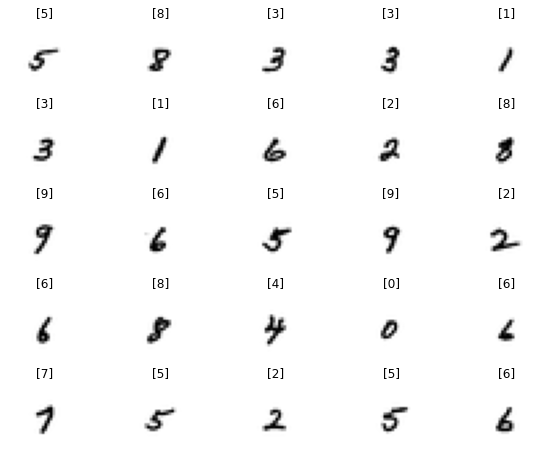

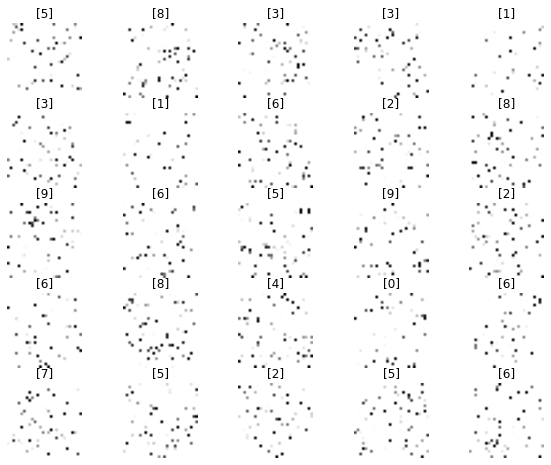

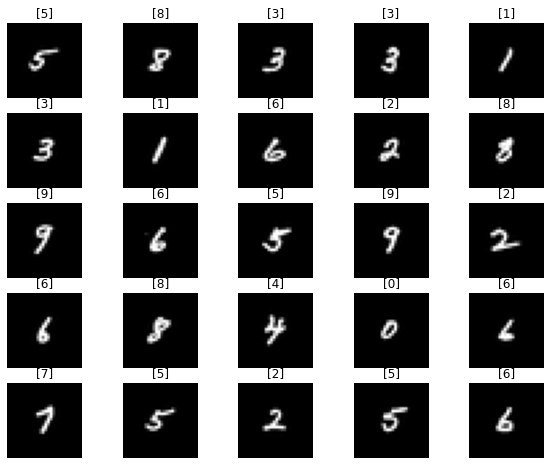

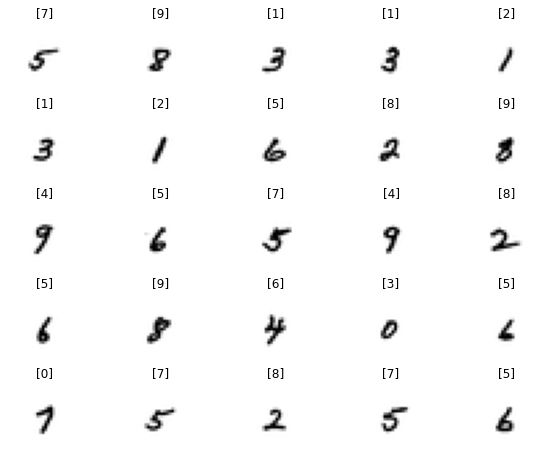

In [5]:
draw_samples(raw_train_data, eavesdroppers_idx[0])
draw_samples(raw_train_attacked_1, eavesdroppers_idx[0])
draw_samples(raw_train_attacked_2, eavesdroppers_idx[0])
draw_samples(raw_train_attacked_3, eavesdroppers_idx[0])

In [43]:
fed_test_dataloader = fl.create_femnist_server_test_dataloader(
    raw_test_data, workers_idx_to_be_used, batch_size=configs['runtime']['test_batch_size'])

2020-12-19 01:41:19,777 Creating femnist test dataloader possibly for the server from 30 workers
2020-12-19 01:41:19,778 Extract data from raw data for 30 of users...
2020-12-19 01:41:19,788 Aggregated test dataset: len: 491
2020-12-19 01:41:19,789 Aggregated test dataloader: Batch Num: 32, Total samples: 480


In [46]:
len(fed_test_dataloader.dataset)

491

In [10]:
count = 0
for ww in workers_idx_to_be_used:
    count += len(raw_test_data[ww]['y'])
print(count)
print(32 * 15)

491
480


In [34]:
fed_train_datasets = fl.create_femnist_train_datasets(raw_train_data, workers_idx_to_be_used)

2020-12-19 00:46:35,377 Scanning and sending data to f0933_38...
/home/savi/ehsan/venv/src/syft/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
2020-12-19 00:46:35,399 Scanning and sending data to f0504_29...
2020-12-19 00:46:35,420 Scanning and sending data to f0840_37...
2020-12-19 00:46:35,448 Scanning and sending data to f0519_46...
2020-12-19 00:46:35,463 Scanning and sending data to f0644_19...
2020-12-19 00:46:35,493 Scanning and sending data to f0590_06...
2020-12-19 00:46:35,523 Scanning and sending data to f0958_28...
2020-12-19 00:46:35,557 Scanning and sending data to f0717_46...
2020-12-19 00:46:35,588 Scanning and sending data to f0566_02...
2020-12-19 00:46:35,613 Scanning and sending data to f0795_37...
2020-12-19 00:46:

In [16]:
count = 0
for ww in workers_idx_to_be_used:
    count += len(raw_train_data[ww]['y'])
print(count)

3205


In [33]:
count = 0
for ww_id, data in fed_train_datasets.items():
    count += len(data.datasets[ww_id].targets.get())
#     count += len(data)
print(count)
# dir(fed_train_datasets)

3205


In [39]:
fed_train_dataloaders = dict()
for ww_id, fed_dataset in fed_train_datasets.items():
    dataloader = sy.FederatedDataLoader(
        fed_dataset, batch_size=configs['runtime']['batch_size'], shuffle=False, drop_last=True)
    fed_train_dataloaders[fed_dataset.workers[0]] = dataloader

In [42]:
len(workers_idx_to_be_used)

30

In [41]:
[1.0 / len(workers_idx_to_be_used)] * len(workers_idx_to_be_used)

[0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333]

In [40]:
fed_train_dataloaders['f0933_38'].batch_size

15

In [38]:
count = 0
for ww, dataloader in fed_train_dataloaders.items():
    print("{} ------------------".format(ww))
    count_locally = 0
    for bb, (dd, tt) in enumerate(dataloader):
        count_locally += len(tt.get())
        print(bb, count_locally)
    count += count_locally
    print("Global: {}".format(count))

f0933_38 ------------------
0 15
1 30
2 45
3 60
4 75
5 90
Global: 90
f0504_29 ------------------
0 15
1 30
2 45
3 60
4 75
5 90
Global: 180
f0840_37 ------------------
0 15
1 30
2 45
3 60
4 75
5 90
Global: 270
f0519_46 ------------------
0 15
1 30
2 45
3 60
4 75
5 90
6 105
Global: 375
f0644_19 ------------------
0 15
1 30
2 45
3 60
4 75
5 90
6 105
Global: 480
f0590_06 ------------------
0 15
1 30
2 45
3 60
4 75
5 90
6 105
Global: 585
f0958_28 ------------------
0 15
1 30
2 45
3 60
4 75
5 90
Global: 675
f0717_46 ------------------
0 15
1 30
2 45
3 60
4 75
5 90
Global: 765
f0566_02 ------------------
0 15
1 30
2 45
3 60
4 75
5 90
Global: 855
f0795_37 ------------------
0 15
1 30
2 45
3 60
4 75
5 90
6 105
Global: 960
f0898_29 ------------------
0 15
1 30
2 45
3 60
4 75
5 90
Global: 1050
f0626_23 ------------------
0 15
1 30
2 45
3 60
4 75
5 90
Global: 1140
f0701_21 ------------------
0 15
1 30
2 45
3 60
4 75
5 90
6 105
Global: 1245
f0864_41 ------------------
0 15
1 30
2 45
3 60
4 75
5 90
